In [1]:
import numpy as np
import pandas as pd
import scipy as sci
import sklearn as skl
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('maxent_ne_chunker_tab')
nltk.download('words')
nltk.download('vader_lexicon')

plt.style.use("Solarize_Light2")

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/titanjuels/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/titanjuels/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker_tab to
[nltk_data]     /Users/titanjuels/nltk_data...
[nltk_data]   Package maxent_ne_chunker_tab is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/titanjuels/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/titanjuels/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


This is my sentiment analysis project, i will be using the amazon fine food dataset

In [2]:
df = pd.read_csv("data/Reviews.csv")
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


Check its clean

In [3]:
df.isna().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               26
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

In [4]:
df.shape

(568454, 10)

A little too large for my liking, so we'll use the first 5000

In [5]:
df = df.head(5000) # Change this to the number of points we want

In [6]:
df.shape

(500, 10)

<Axes: title={'center': 'Rating Frequencies'}, xlabel='Score'>

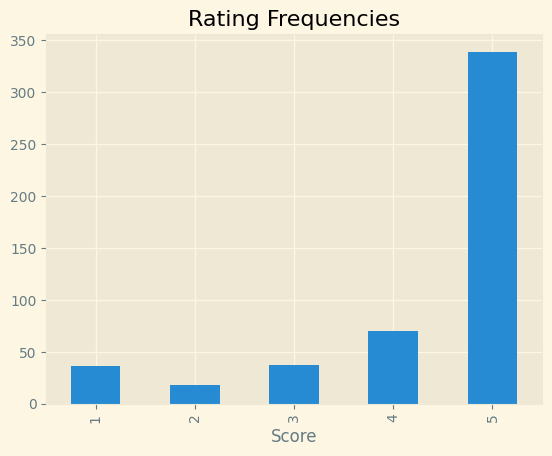

In [7]:
# EDA STEP
df["Score"].value_counts().sort_index().plot(kind='bar', title='Rating Frequencies')

In [8]:
# Messing with NLTK
ex = df['Text'][350]
print(ex)

These chocolate covered espresso beans are wonderful!  The chocolate is very dark and rich and the "bean" inside is a very delightful blend of flavors with just enough caffine to really give it a zing.


In [9]:
# i would expect positive sentiment and solid 'helpfulness'
tokens = nltk.word_tokenize(ex)
tokens[:10]

['These',
 'chocolate',
 'covered',
 'espresso',
 'beans',
 'are',
 'wonderful',
 '!',
 'The',
 'chocolate']

In [10]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('These', 'DT'),
 ('chocolate', 'NN'),
 ('covered', 'VBD'),
 ('espresso', 'JJ'),
 ('beans', 'NNS'),
 ('are', 'VBP'),
 ('wonderful', 'JJ'),
 ('!', '.'),
 ('The', 'DT'),
 ('chocolate', 'NN')]

In [11]:
chunked = nltk.chunk.ne_chunk(tagged)
chunked.pprint()

(S
  These/DT
  chocolate/NN
  covered/VBD
  espresso/JJ
  beans/NNS
  are/VBP
  wonderful/JJ
  !/.
  The/DT
  chocolate/NN
  is/VBZ
  very/RB
  dark/JJ
  and/CC
  rich/JJ
  and/CC
  the/DT
  ``/``
  bean/NN
  ''/''
  inside/NN
  is/VBZ
  a/DT
  very/RB
  delightful/JJ
  blend/NN
  of/IN
  flavors/NNS
  with/IN
  just/RB
  enough/RB
  caffine/NN
  to/TO
  really/RB
  give/VB
  it/PRP
  a/DT
  zing/NN
  ./.)


### VADER
I will now attempt to use VADER scoring in order to rate the scores. A problem with this appraoch compared to BERT is that VADER doesn't recognize relationships between words (i.e. context). So, smth like, "I really really really really don't like this product!", might be rated as a positive sentiment, as 'really' may be determined as positive, so 4 positives and 1 negative might be positive overall. You get the picture.

But this seems like an approach i might come up with, so i want to try it.

In [12]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()
sia.polarity_scores("I am super happy!")

{'neg': 0.0, 'neu': 0.112, 'pos': 0.888, 'compound': 0.8356}

In [13]:
# Out of curiousity
sia.polarity_scores("I really really really really don't like this product!")

{'neg': 0.296, 'neu': 0.704, 'pos': 0.0, 'compound': -0.4486}

In [14]:
# im also curious, i'll use a sentence i consider to be neutral/positive
sia.polarity_scores("It's not the worst thing ever")

{'neg': 0.0, 'neu': 0.603, 'pos': 0.397, 'compound': 0.5096}

Fortunately its not as naive as what i had imagined, but lets continue.

In [15]:
score_on_ex = sia.polarity_scores(ex)
score_on_ex

{'neg': 0.0, 'neu': 0.715, 'pos': 0.285, 'compound': 0.9177}

In [16]:
# Now I'll go through the entire dataset, creating a new dataframe with all the scores, corresponding to that id
scored_df = df['Text'].apply(sia.polarity_scores).apply(pd.Series)
scored_df['Id'] = df['Id']
scored_df = scored_df[['Id', 'neg', 'neu', 'pos', 'compound']]
scored_df.head()

,Id,neg,neu,pos,compound
0,1,0.000,0.695,0.305,0.9441
1,2,0.138,0.862,0.000,-0.5664
2,3,0.091,0.754,0.155,0.8265
3,4,0.000,1.000,0.000,0.0000
4,5,0.000,0.552,0.448,0.9468


In [17]:
# Now we can easily index from the df to find the score for that comment in the 'scored_df'
vader_df = scored_df.merge(df, how='left')
vader_df.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


We'll assume score of 5 means more positive 'Text', and score of 1 means more negative 'Text'.

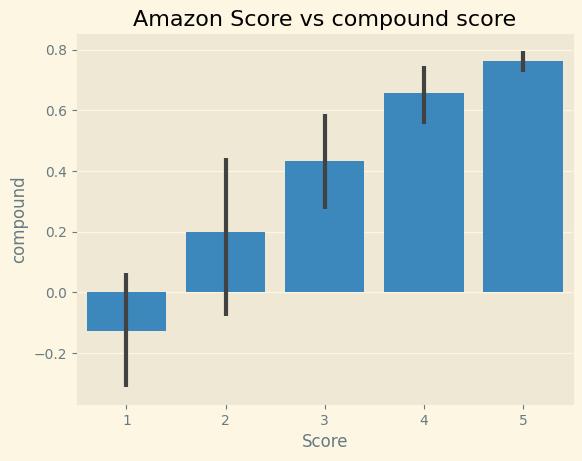

In [18]:
ax1 = sns.barplot(vader_df, x='Score', y='compound')
ax1.set_title("Amazon Score vs compound score")
plt.show()

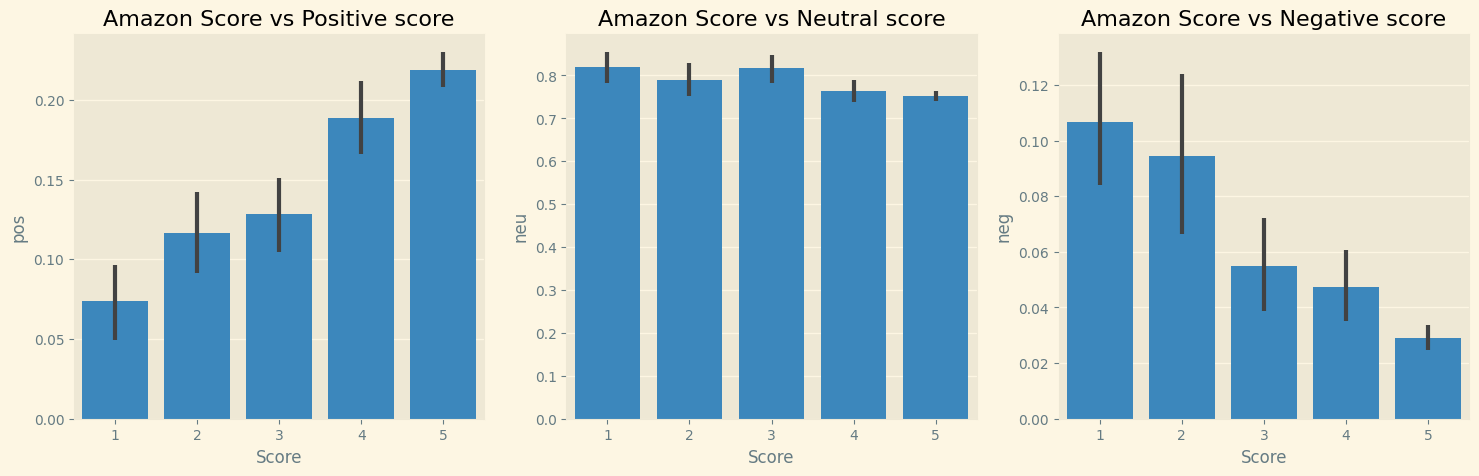

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(18,5))
sns.barplot(vader_df, x='Score', y='pos', ax=axs[0])
sns.barplot(vader_df, x='Score', y='neu', ax=axs[1])
sns.barplot(vader_df, x='Score', y='neg', ax=axs[2])
axs[0].set_title("Amazon Score vs Positive score")
axs[1].set_title("Amazon Score vs Neutral score")
axs[2].set_title("Amazon Score vs Negative score")
plt.show()

We can see it follows the expected trend, generally more positives as the review gets higher, and less negatives as the review score increses. Neutrality is somewhat insignificant.

### BERT MODEL
I will now try to implement using transformers through the BERT model and I will compare the performance.

In [20]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [21]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [22]:
# From vader sentiment analysis
print(score_on_ex)

{'neg': 0.0, 'neu': 0.715, 'pos': 0.285, 'compound': 0.9177}


In [23]:
# BERT instead
encoded_ex = tokenizer(ex, return_tensors='pt')
print(encoded_ex)

# Will be a tensort
output = model(**encoded_ex)
print(output)

# convert to numpy
np_output = output[0][0].detach().numpy()

{'input_ids': tensor([[    0,  4528,  7548,  2913, 35592, 13095,    32,  4613,   328,  1437,
            20,  7548,    16,   182,  2933,     8,  4066,     8,     5,    22,
         16595,   113,  1025,    16,    10,   182, 24897, 11739,     9, 14250,
            19,    95,   615,  6056,  3145,   833,     7,   269,   492,    24,
            10,   992,   154,     4,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
SequenceClassifierOutput(loss=None, logits=tensor([[-2.5786, -0.6934,  4.0527]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)


In [24]:
res = softmax(np_output)
print(ex)
print(f"Negative: {res[0]}, Neutral: {res[1]}, Positive: {res[2]}")

These chocolate covered espresso beans are wonderful!  The chocolate is very dark and rich and the "bean" inside is a very delightful blend of flavors with just enough caffine to really give it a zing.
Negative: 0.0013054243754595518, Neutral: 0.00859999842941761, Positive: 0.9900946021080017


Which is more what we would expect form the example, we know its completely a good review, and the BERT score reflects that more accurately than the vader score

In [25]:
def roberta_scorer(item):
    encoded_ex = tokenizer(item, return_tensors='pt')
    output = model(**encoded_ex)
    np_output = output[0][0].detach().numpy()
    res = softmax(np_output)
    scores_dict = {
        "rob_neg" : res[0],
        "rob_neu" : res[1],
        "rob_pos" : res[2],
    }
    return scores_dict  # <-- Add this line!

scores = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        currId = row['Id']
        rob = roberta_scorer(text)
        vader = sia.polarity_scores(text)
        vader_renamed = {
            "vader_neg" : vader["neg"],
            "vader_neu" : vader["neu"],
            "vader_pos" : vader["pos"],
        }
        scores[currId] = { **rob, **vader_renamed }
    except RuntimeError:
        print(f"Broke for id: {currId}")
        
# If you want to create a dataframe from scores:
scored_roberta_df = pd.DataFrame.from_dict(scores, orient='index')
scored_roberta_df.head()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/500 [00:00<?, ?it/s]

Broke for id: 83
Broke for id: 187


,rob_neg,rob_neu,rob_pos,vader_neg,vader_neu,vader_pos
1,0.009624,0.049980,0.940395,0.000,0.695,0.305
2,0.508986,0.452414,0.038600,0.138,0.862,0.000
3,0.003229,0.098067,0.898704,0.091,0.754,0.155
4,0.002295,0.090219,0.907486,0.000,1.000,0.000
5,0.001635,0.010302,0.988063,0.000,0.552,0.448


In [26]:
# There are some issues for these id's as the text is a little too long
scored_roberta_df['Id'] = df['Id']
scored_roberta_df.index -= 1
final_df = scored_roberta_df.merge(df, how='left')
final_df.head()

,rob_neg,rob_neu,rob_pos,vader_neg,vader_neu,vader_pos,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,0.009624,0.049980,0.940395,0.000,0.695,0.305,2.0,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0.0,0.0,1.0,1.346976e+09,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
1,0.508986,0.452414,0.038600,0.138,0.862,0.000,3.0,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1.0,1.0,4.0,1.219018e+09,"""Delight"" says it all",This is a confection that has been around a fe...
2,0.003229,0.098067,0.898704,0.091,0.754,0.155,4.0,B000UA0QIQ,A395BORC6FGVXV,Karl,3.0,3.0,2.0,1.307923e+09,Cough Medicine,If you are looking for the secret ingredient i...
3,0.002295,0.090219,0.907486,0.000,1.000,0.000,5.0,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0.0,0.0,5.0,1.350778e+09,Great taffy,Great taffy at a great price. There was a wid...
4,0.001635,0.010302,0.988063,0.000,0.552,0.448,6.0,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0.0,0.0,4.0,1.342051e+09,Nice Taffy,I got a wild hair for taffy and ordered this f...


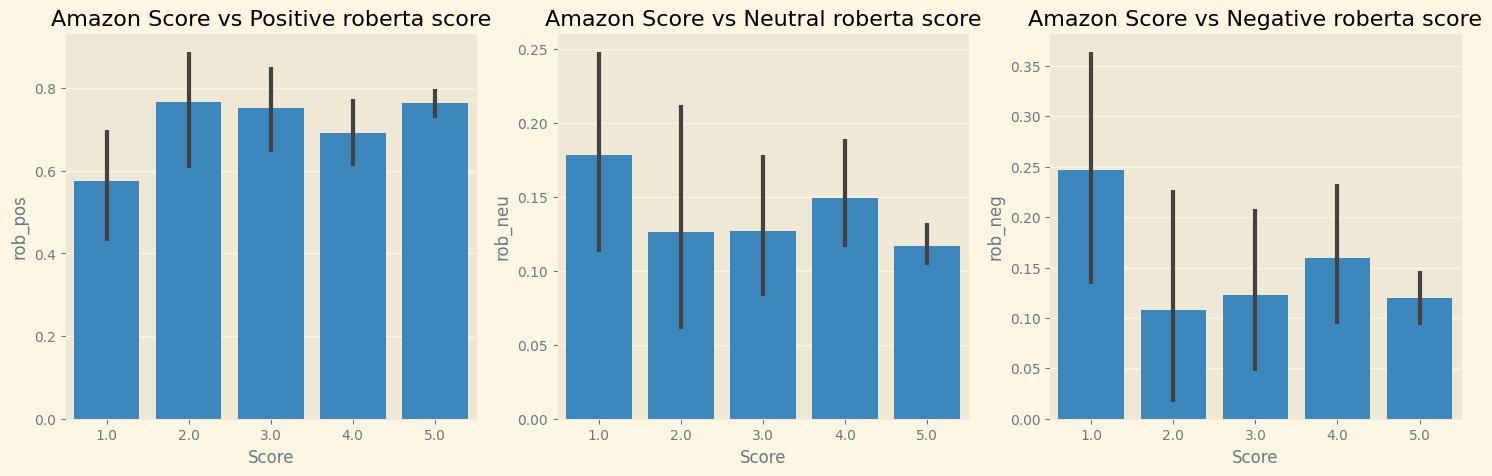

In [27]:
fig, ax1s = plt.subplots(1, 3, figsize=(18,5))
sns.barplot(final_df, x='Score', y='rob_pos', ax=ax1s[0])
sns.barplot(final_df, x='Score', y='rob_neu', ax=ax1s[1])
sns.barplot(final_df, x='Score', y='rob_neg', ax=ax1s[2])
ax1s[0].set_title("Amazon Score vs Positive roberta score")
ax1s[1].set_title("Amazon Score vs Neutral roberta score")
ax1s[2].set_title("Amazon Score vs Negative roberta score")
plt.show()

We can see the change between columns is a bit steeper, indicating that the model is doing better at decerning the differing sentiment for each model.

In [28]:
final_df.columns

Index(['rob_neg', 'rob_neu', 'rob_pos', 'vader_neg', 'vader_neu', 'vader_pos',
       'Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

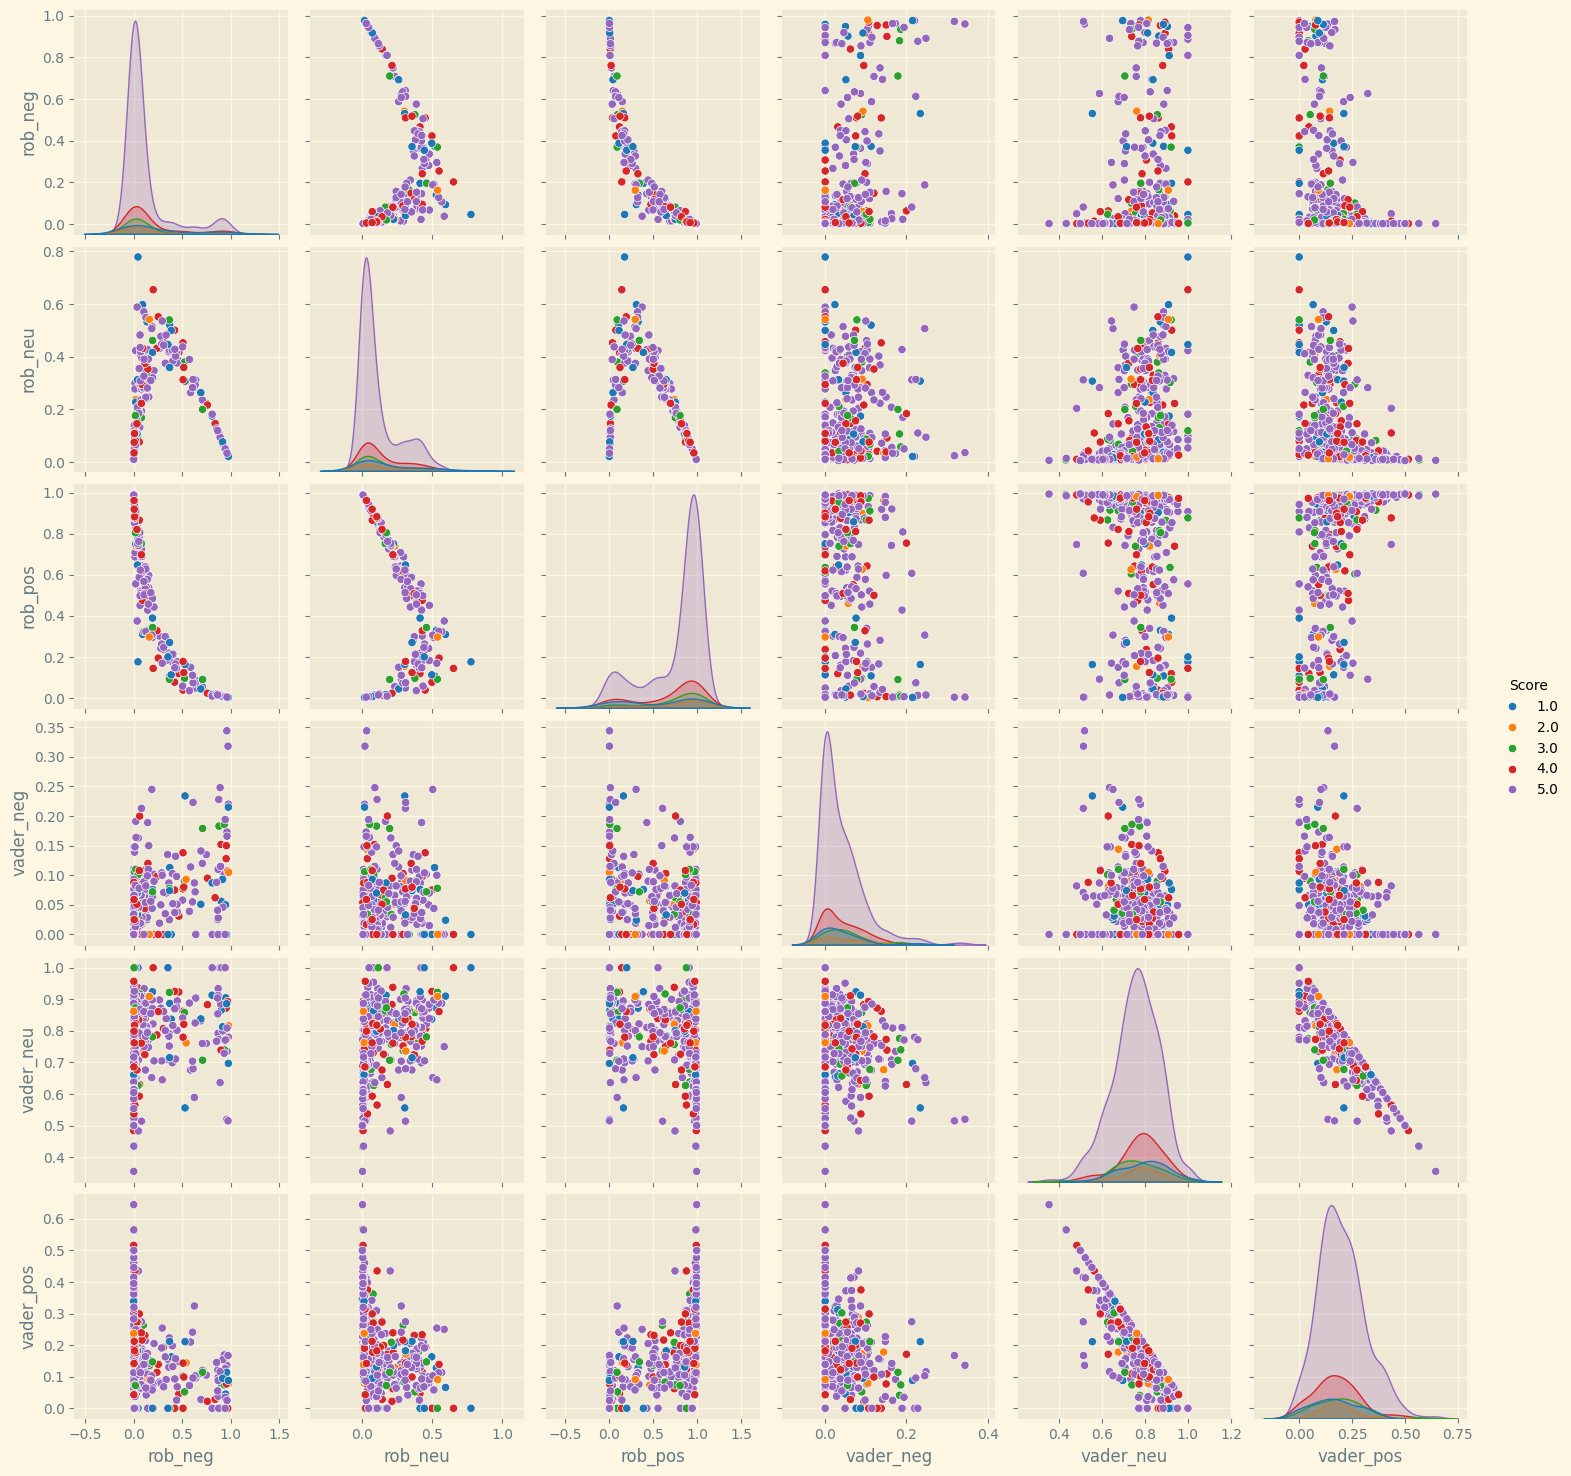

In [31]:
sns.pairplot(data=final_df, 
             vars=['rob_neg', 'rob_neu', 'rob_pos', 'vader_neg', 'vader_neu', 'vader_pos'],
             hue="Score",
             palette='tab10'
            )
plt.show()

### Interesting examples to consider are ones with a large disparity between Amazon score and the model sentiment's score

In [38]:
final_df.query('Score == 1').sort_values('rob_pos', ascending=False)['Text'].values[0]

'I so wish I would have read this review before purchasing TWO gallons of this oil for my health issues. It reeks like a chemical rubber smell. This smell is coming from the black rubber gasket in the lid. When I called to report the situation to the company, Sabrina told me I would have to pay to send them a sample to have tested by a lab. Unbelievable. Good customer service would indicate that they would pay for the product to be returned and give me a full refund, including shipping. The product is faulty. Period. I will never order anything from this company again and do not recommend it to anyone based on this horrible customer service and lack of responsibility and ownership.'

In [43]:
final_df.query('Score == 1').sort_values('vader_pos', ascending=False)['Text'].values[0]

"I don't know how long these sat on the back of a shelf somewhere, but they were so old that they wouldn't cook.  I had to throw half of them out, because the skins were damaged, a clear sign of dried beans past their prime.  I can't even return these or ask for a refund, because food is not returnable.  Will find a different brand to use.  For now, I have about fifty servings of beans to throw away."

It seems to struggle with larger text, and the rob model seems to also have gotten confused dealing with thethird sentence, 'Good customer service ...'. It has a extremely high rob_pos score.

In [42]:
final_df.query('Score == 5').sort_values('rob_neg', ascending=False)['Text'].values[0]

'Got a free package of these with a bottle of bloody mary mix I bought from the seller, and the advertising worked..lol,  I tried them, and shared them with 2 buddies, and we all loved them...  So im here to buy more, and noticed there were no reviews yet,...  well now there is.  They are Hot,  but not "burn your mouth forever hot"  its a nice temp...  Perfect for us..'

It also mislassified this one, likely due to the amount of puncuation.

In [44]:
final_df.query('Score == 5').sort_values('vader_neg', ascending=False)['Text'].values[0]

"These Albanese gummi bears and rings and so on are very good and tasty and high quality. The bears even have little faces. At my local candy store this type of gummi stuff (bears, rings, snakes, balls, worms, whatever) are about $10/lb. These twin packs of 4.5 or 5 pound bags is a screaming deal as far as I'm concerned. I'm probably 50 pounds deep in these friggin' things. Consumed!"

Complaints about the other brand mentioned seems to have been misinterpreted as complaints about the amazon product.

### A little extra
Learning another slightly easier way to make analysis.

In [46]:
from transformers import pipeline

sent_pipeline = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use mps:0


In [47]:
sent_pipeline("I am so stoked to see these on amazon, this is a product i have been using for years with no complaints")

[{'label': 'POSITIVE', 'score': 0.9952270984649658}]

Using a random message i thought of, it is able to correctly identify. And seems like it is more usable for generalized classifications. i.e. we can just check score['label']  to find out if its positive or negative.

In [48]:
# Similarly
sent_pipeline("This gel is so oily, uncomfortable, and itchy. I'm scratching my head the whole day.")

[{'label': 'NEGATIVE', 'score': 0.9983398914337158}]

### Final Thoughts
Before implementing this, i read the paper that introduced BERT [here](https://arxiv.org/pdf/1810.04805v2), and the one I believed that introduced VADER [here](https://ojs.aaai.org/index.php/ICWSM/article/view/14550/14399). 
I find it interesting the confidence the BERT model has in the analyses, like 0.995, compared to the VADER model, which even for highly negative or positive reviews, was still more of a mix.